# Architecture 1 - Naive Model

## Exp. 1 - Simple Conv. Model
## Exp. 2 - Adding Dropout to prevent Overfitiing
## Exp. 3 - Added Layers and Batch Normalization
<br>

Inon Elgabsi: 207709551

Nati Forish: 208687004

Iyar Gadolov: 206905754

Roy Edri: 214099046


## Download libraries

In [ ]:
%%capture
!pip install ipython-autotime
!pip install kagglehub
!pip install ipywidgets
!pip install pillow
!pip install matplotlib
!pip install scipy
%load_ext autotime

time: 384 µs (started: 2025-03-19 16:32:46 +00:00)


## Login Kaggle Account

In [ ]:
import kagglehub
kagglehub.login()

time: 277 ms (started: 2025-03-19 16:32:46 +00:00)
Kaggle credentials set.
Kaggle credentials successfully validated.


## Download dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download("davemahony/20-uk-garden-birds")

print("Path to dataset files:", path)

100%|██████████| 378M/378M [00:01<00:00, 202MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/davemahony/20-uk-garden-birds/versions/7
time: 7.46 s (started: 2025-03-19 16:32:59 +00:00)


## Define dataset location


In [ ]:
import shutil
import os

source_path = path
root_path = "/content"
destination_path = os.path.join(root_path, "birds_dataset")

shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print(f"Data Copied to {destination_path}")


Data Copied to /content/birds_dataset
time: 912 ms (started: 2025-03-19 16:33:14 +00:00)


## Creat train, test folders

In [ ]:
import os
import shutil
import random

dataset_path = r"/content/birds_dataset/withBackground"

train_path = r"/content/birds_dataset/train"
val_path   = r"/content/birds_dataset/val"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

categories = os.listdir(dataset_path)

for category in categories:
    src_folder = os.path.join(dataset_path, category)

    if not os.path.isdir(src_folder):
        continue

    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(val_path, category), exist_ok=True)

    images = os.listdir(src_folder)
    random.shuffle(images)

    split_idx = int(len(images) * 0.8)

    for img in images[:split_idx]:
        shutil.copy(os.path.join(src_folder, img), os.path.join(train_path, category, img))

    for img in images[split_idx:]:
        shutil.copy(os.path.join(src_folder, img), os.path.join(val_path, category, img))

print("Train and Validation Splited Successfully")


Train and Validation Splited Successfully
time: 452 ms (started: 2025-03-19 16:33:18 +00:00)


## Create Image Generators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_path = r"/content/birds_dataset/train"
val_path   = r"/content/birds_dataset/val"

train_rgb_generator = datagen.flow_from_directory(
    directory=train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=True
)

val_rgb_generator = datagen.flow_from_directory(
    directory=val_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode=None,
    shuffle=True
)

def colorization_generator(rgb_generator):
    while True:
        for batch in rgb_generator:
            batch_gray = tf.image.rgb_to_grayscale(batch)
            yield (batch_gray, batch)

train_generator = colorization_generator(train_rgb_generator)
val_generator = colorization_generator(val_rgb_generator)


Found 2270 images belonging to 20 classes.
Found 571 images belonging to 20 classes.
time: 3.43 s (started: 2025-03-19 16:33:21 +00:00)


# Model 1 - Exp. 1
## Basic/Naive Model

**Establish a basic CNN-based encoder–decoder as a starting point for image colorization.**

**Architecture & Hyperparameters:**
- Encoder: Three convolutional layers with 64, 128, and 256 filters, respectively. Each layer uses ReLU activation and is followed by max pooling (with “same” padding) to progressively downsample the input.
- Decoder: Mirrors the encoder using upsampling layers followed by convolutional layers to reconstruct the 3-channel (RGB) output.
- Loss Function: Mean Squared Error (MSE)
- Optimizer: Adam with a learning rate of 2e-4

Training: 20 epochs, batch size = 32

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer

model = Sequential()

# Encoder
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

# Decoder
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))

model.summary()

print("Train samples:", train_rgb_generator.samples)
print("Validation samples:", val_rgb_generator.samples)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,307 (5.07 MB)

 Trainable params: 1,330,307 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Train samples: 2270
Validation samples: 571
time: 2.57 s (started: 2025-03-19 16:33:25 +00:00)


## Training

In [ ]:
import scipy

model.compile(optimizer='adam', loss='mean_squared_error')

epochs = 20
steps_per_epoch = train_rgb_generator.samples // train_rgb_generator.batch_size
validation_steps = val_rgb_generator.samples // val_rgb_generator.batch_size

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - loss: 0.0434 - val_loss: 0.0180
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 11

## Show Plots and Predicted Images

**Observations:**

- The model successfully learns the basic mapping from grayscale to color.

- The output tends to be low in saturation and lacks fine details, indicating that the representational capacity may be limited for capturing complex color patterns.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


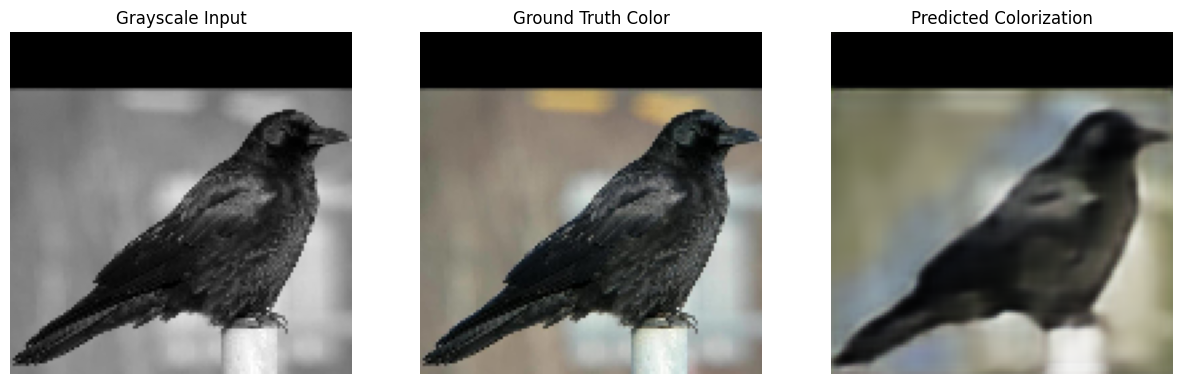

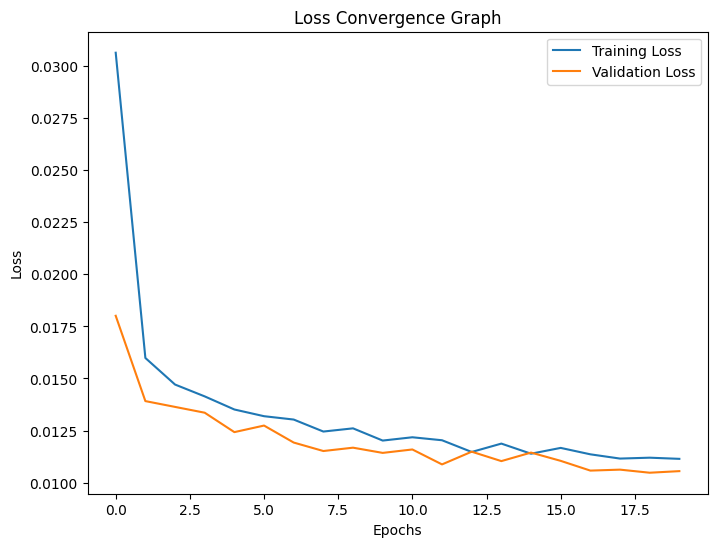

time: 1.22 s (started: 2025-03-19 16:37:39 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

gray_val, rgb_val = next(val_generator)

predicted_val = model.predict(gray_val)

index = 0
gray_img = tf.squeeze(gray_val[index]).numpy()
gt_img   = rgb_val[index]
pred_img = predicted_val[index]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_img)
plt.title("Ground Truth Color")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_img)
plt.title("Predicted Colorization")
plt.axis("off")

plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Convergence Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model 1 - Exp. 2
## Adding Dropout to prevent Overfitiing

**Mitigate overfitting observed in the baseline model by incorporating dropout layers.**

**Architecture Modifications:**

- Dropout Layers: Introduced dropout (rate = 0.2) after key convolutional layers in the encoder to randomly deactivate neurons during training.
- The overall encoder–decoder architecture remains similar to Experiment 1.

**Hyperparameters & Training:**
- Loss Function & Optimizer: MSE loss with Adam optimizer (2e-4).
- Training: Extended to 50 epochs (batch size = 32) to better assess the effect of dropout.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Dropout

model_exp2 = Sequential()

# Encoder
model_exp2.add(InputLayer(input_shape=(128, 128, 1)))
model_exp2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_exp2.add(MaxPooling2D((2,2), padding='same'))
model_exp2.add(Dropout(0.2))
model_exp2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_exp2.add(MaxPooling2D((2,2), padding='same'))
model_exp2.add(Dropout(0.2))
model_exp2.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_exp2.add(MaxPooling2D((2,2), padding='same'))

# Decoder
model_exp2.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2,2)))
model_exp2.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2,2)))
model_exp2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2,2)))
model_exp2.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))

model_exp2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,307 (5.07 MB)

 Trainable params: 1,330,307 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

time: 130 ms (started: 2025-03-18 17:34:11 +00:00)


## Training

In [ ]:
model_exp2.compile(optimizer='adam', loss='mean_squared_error')

history_exp2 = model_exp2.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_rgb_generator.samples // train_rgb_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_rgb_generator.samples // val_rgb_generator.batch_size
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - loss: 0.0459 - val_loss: 0.0346
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.0171 - val_loss: 0.0293
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 0.0153 - val_loss: 0.0236
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - loss: 0.0144 - val_loss: 0.0230
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 0.0143 - val_loss: 0.0232
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - loss: 0.0139 - val_loss: 0.0215
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - loss: 0.0132 - val_loss: 0.0172
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - loss: 0.0131 - val_loss: 0.0199
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0129 - val_loss: 0.0170
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - loss: 0.0125 - val_loss: 0.0144
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s

## Show Plots and Predicted Images

**Observations:**
- Dropout helped reduce overfitting, as evidenced by a more similar training and validation loss.
- A slight degradation in color sharpness was noted, suggesting that while generalization improved, some fine details were lost.

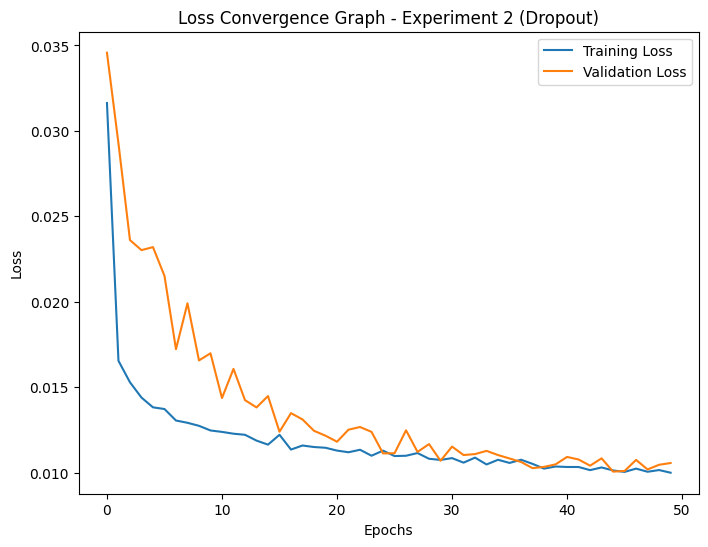

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


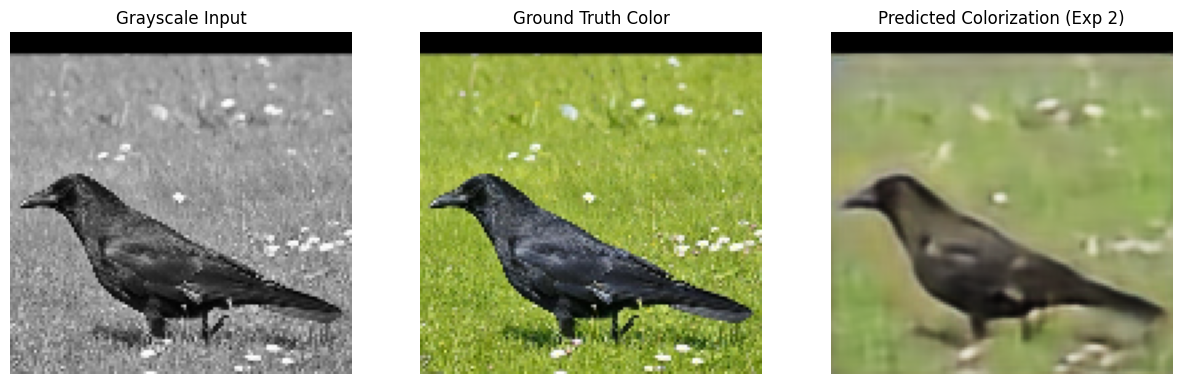

time: 1.14 s (started: 2025-03-18 17:45:54 +00:00)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(history_exp2.history['loss'], label='Training Loss')
plt.plot(history_exp2.history['val_loss'], label='Validation Loss')
plt.title('Loss Convergence Graph - Experiment 2 (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# הצגת תוצאה לדוגמה
gray_val, rgb_val = next(val_generator)
predicted_val = model_exp2.predict(gray_val)

index = 0
import tensorflow as tf
gray_img = tf.squeeze(gray_val[index]).numpy()
gt_img   = rgb_val[index]
pred_img = predicted_val[index]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_img)
plt.title("Ground Truth Color")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_img)
plt.title("Predicted Colorization (Exp 2)")
plt.axis("off")
plt.show()

# Model 1 - Exp. 3
## Added Layers and Batch Normalization

Enhance the network’s performance by increasing its depth and using Batch Normalization to stabilize and accelerate training.

Architecture Modifications:

- Deeper Encoder: Expanded the network to four convolutional blocks with increasing filter counts (64, 128, 256, 512).
- Batch Normalization: Applied after each convolutional layer to improve training stability, mitigate vanishing/exploding gradients, and accelerate convergence.
- Decoder: Uses Conv2DTranspose layers (with strides of 2) combined with Batch Normalization to reconstruct the image.

**Hyperparameters & Training:**
- Loss Function & Optimizer: MSE loss with Adam optimizer (2e-4).
- Training: 70 epochs, batch size = 32.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, InputLayer, BatchNormalization

model_exp3 = Sequential()

# Encoder
model_exp3.add(InputLayer(input_shape=(128, 128, 1)))
model_exp3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(MaxPooling2D((2,2), padding='same'))

model_exp3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(MaxPooling2D((2,2), padding='same'))

model_exp3.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(MaxPooling2D((2,2), padding='same'))

model_exp3.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(MaxPooling2D((2,2), padding='same'))

# Decoder - Upsampling using Conv2DTranspose with strides (Each Layer - x2)
model_exp3.add(Conv2DTranspose(512, (3,3), strides=(2,2), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())
model_exp3.add(Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same'))
model_exp3.add(BatchNormalization())

# RBG with Sigmoid
model_exp3.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))

model_exp3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,467,779 (20.86 MB)

 Trainable params: 5,463,939 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

time: 533 ms (started: 2025-03-18 20:06:57 +00:00)


## Training

In [ ]:
model_exp3.compile(optimizer='adam', loss='mean_squared_error')

history_exp3 = model_exp3.fit(
    train_generator,
    epochs=70,
    steps_per_epoch=train_rgb_generator.samples // train_rgb_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_rgb_generator.samples // val_rgb_generator.batch_size
)


Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - loss: 0.0398 - val_loss: 0.0543
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - loss: 0.0182 - val_loss: 0.0500
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - loss: 0.0162 - val_loss: 0.0442
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 337ms/step - loss: 0.0152 - val_loss: 0.0410
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - loss: 0.0148 - val_loss: 0.0315
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - loss: 0.0138 - val_loss: 0.0242
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 323ms/step - loss: 0.0141 - val_loss: 0.0211
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 9/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.0130 - val_loss: 0.0150
Epoch 10/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - loss: 0.0130 - val_loss: 0.0151
Epoch 11/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - loss: 0.0127 - val_loss: 0.0149
Epoch 12/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 17

## Show Plots and Predicted Images

**Observations:**

- Training stability improved significantly due to Batch Normalization.
- The deeper architecture produced sharper, more vibrant, and color-accurate outputs with reduced blur compared to previous experiments.
- Overall, this configuration achieved the best balance between learning capacity and generalization.

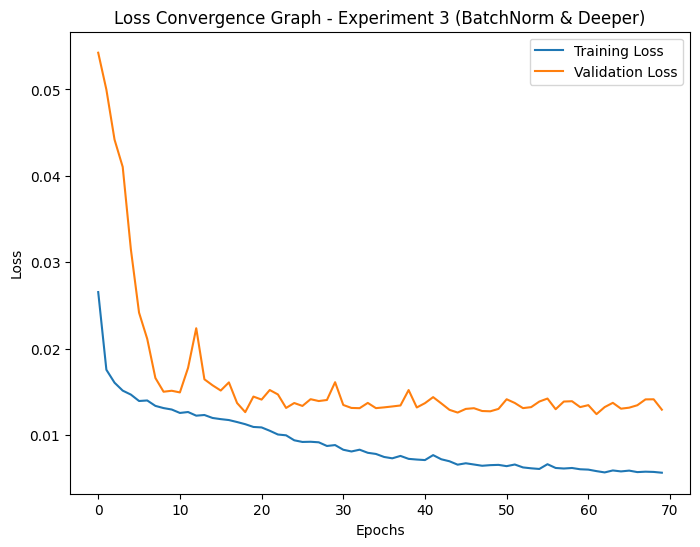

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


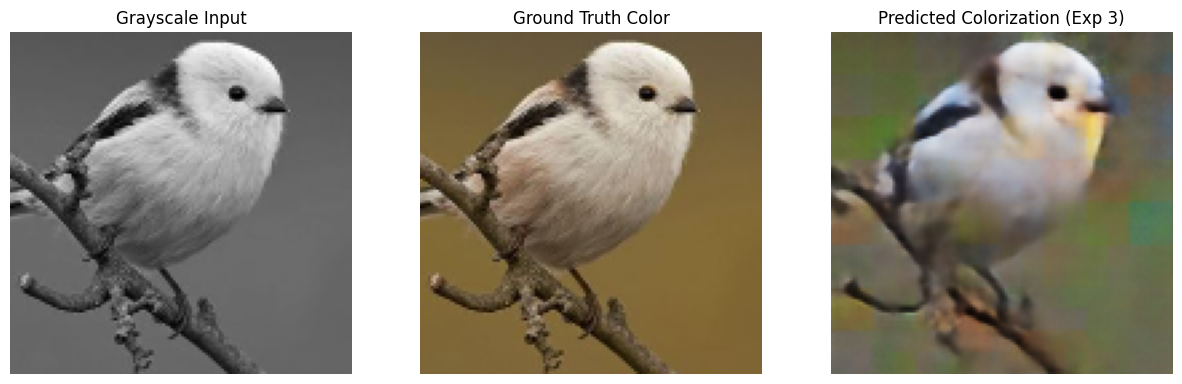

time: 733 ms (started: 2025-03-18 20:28:38 +00:00)


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history_exp3.history['loss'], label='Training Loss')
plt.plot(history_exp3.history['val_loss'], label='Validation Loss')
plt.title('Loss Convergence Graph - Experiment 3 (BatchNorm & Deeper)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

gray_val, rgb_val = next(val_generator)
predicted_val = model_exp3.predict(gray_val)

index = 0
gray_img = tf.squeeze(gray_val[index]).numpy()
gt_img   = rgb_val[index]
pred_img = predicted_val[index]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Input")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_img)
plt.title("Ground Truth Color")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_img)
plt.title("Predicted Colorization (Exp 3)")
plt.axis("off")
plt.show()

**Summary of Notebook 1 Experiments**
- Experiment 1: Established a baseline that learned basic colorization, but outputs were low in saturation and lacked detail.
- Experiment 2: Incorporating dropout helped reduce overfitting but slightly compromised image sharpness.
- Experiment 3: A deeper network with Batch Normalization provided the best visual quality and stability, yielding more precise and vibrant colorization.

These experiments illustrate how incremental architectural improvements and regularization techniques can enhance performance in cnn models for image colorization.

In [ ]:
best_model = model_exp3

# Saving the best model (exp. 3)
best_model.save('arch-1-best-model.h5')
print("Best model saved as: arch-1-best-model.h5")


Best model saved as: arch-1-best-model.h5
time: 216 ms (started: 2025-03-18 18:06:28 +00:00)
